In [8]:
import os, cv2, torch, math, time, sys
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
from torchvision import transforms
from torch.utils import data

sys.path.append('..')
from load_data.load_dataset import *
from util.utils import *
from data_evaluate import *
from pre.img_enhancement import *

import model.Mobilefacenet_SE as Model

## 创建训练集

In [9]:
name = 'se_0728'
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lr, num_epochs = 0.01, 50

In [10]:
save_dir = r'palm_vein\para'
img_dir = '../dataset/enhance_img'
test_dir = '../dataset/enhance_img2'

train_data = get_data(img_dir)
test_data = get_data(test_dir)
train_iter = get_data_iter(train_data, batch_size)
test_iter = get_data_iter(test_data, batch_size)

num_classes = train_data.classes


In [12]:
name = 'se_0728'
batch_size = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
feature_num = 256
net_para = {'fp16':False,
            'num_features':feature_num}
class_para = {'in_features':feature_num,
              'out_features':train_data.classes}

model = Model.Full_Model(False, 256).to(device)

# 参数量
total = sum([param.nelement() for param in model.parameters()])
print("Number of parameter: %.2fM" % (total/1e6))

criterion = torch.nn.CrossEntropyLoss()
optimizer_ft = optim.SGD([
    {'params': model.parameters()}
], lr=0.1, momentum=0.9, nesterov=True)

Number of parameter: 2.50M


## 搭建模型

In [13]:
multi_gpus = False
RESUME = False

In [15]:
# 不知道为啥第一次开的时候巨小
# 最好开一次，break，再开一次
if RESUME:
    ckpt = torch.load(RESUME)
    model.load_state_dict(ckpt['net_state_dict'])
    start_epoch = ckpt['epoch'] + 1
else:
    start_epoch = 0

test_acc = 0.0
best_acc = 0.0
best_epoch = 0
for epoch in range(start_epoch, num_epochs):
    if epoch>0 and epoch%20==0:
         lr /= 5
    # train model
    metric = Accumulator(3)
    print('Train Epoch: {}/{} ...'.format(epoch+1, num_epochs))
    model.train()

    train_total_loss = 0.0
    total = 0
    since = time.time()
    for idx, data in enumerate(train_iter):
        img, label = data[0].to(device), data[1].to(device)
        batch_size = img.shape[0]
        optimizer_ft.zero_grad()

        output = model(img, label, 'soft')

        total_loss = criterion(output, label)
        total_loss.backward()
        optimizer_ft.step()

        with torch.no_grad():
                metric.add(total_loss.item() * batch_size, 
                           accuracy(output, label), batch_size)

    train_loss = metric[0] / (metric[2]+1e-4)
    train_acc = metric[1] / (metric[2]+1e-4)
    time_elapsed = time.time() - since
    if epoch>0 and epoch % 10 ==0:
        test_acc = evaluate_accuracy(test_iter, model)

    print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, epoch time %.1f sec'
              % (epoch + 1, train_loss, train_acc, 
                 test_acc, 
                 time_elapsed))
'''
    # test model on lfw
    if epoch % TEST_FREQ == 0:
        net.eval()
        featureLs = None
        featureRs = None
        print('Test Epoch: {} ...'.format(epoch))
        for data in testloader:
            for i in range(len(data)):
                data[i] = data[i].cuda()
            res = [net(d).data.cpu().numpy() for d in data]
            featureL = np.concatenate((res[0], res[1]), 1)
            featureR = np.concatenate((res[2], res[3]), 1)
            if featureLs is None:
                featureLs = featureL
            else:
                featureLs = np.concatenate((featureLs, featureL), 0)
            if featureRs is None:
                featureRs = featureR
            else:
                featureRs = np.concatenate((featureRs, featureR), 0)

        result = {'fl': featureLs, 'fr': featureRs, 'fold': folds, 'flag': flags}
        # save tmp_result
        scipy.io.savemat('./result/tmp_result.mat', result)
        accs = evaluation_10_fold('./result/tmp_result.mat')
        _print('    ave: {:.4f}'.format(np.mean(accs) * 100))
'''

Train Epoch: 1/50 ...


TypeError: Linear_Softmax.forward() missing 1 required positional argument: 'y'

In [42]:
evaluate_accuracy(test_iter, model, soft)

0.901

In [43]:
torch.save(model, os.path.join(save_dir, f'model_{name}.pt'))
torch.save(final, os.path.join(save_dir, f'soft_{name}.pt'))

In [44]:
read_model = torch.load(f'./para/model_{name}.pt',map_location=torch.device('cuda'))
read_soft = torch.load(f'./para/soft_{name}.pt',map_location=torch.device('cuda'))
evaluate_accuracy(test_iter, read_model, read_soft)

0.901

In [45]:
def get_feature(data_iter):
    data_tensor = []
    read_model.eval()# 评估模式, 这会关闭dropout
    with torch.no_grad():
        for X_b, y_b in data_iter:
            xx = read_model(X_b.cuda()).cpu()
            for X,y in zip(xx, y_b):
                data_tensor.append([X, y.item()])
    return data_tensor

In [46]:
train_feature = get_feature(train_iter)
test_feature = get_feature(test_iter)

In [47]:
torch.save(train_feature, os.path.join(save_dir, f'train_feature_{name}.pt'))
torch.save(test_feature, os.path.join(save_dir, f'test_feature_{name}.pt'))

In [48]:
train_feature[0]

[tensor([ 0.8888,  2.9698, -0.3431, -2.3977, -0.8264, -1.2213, -1.7418, -1.8570,
         -1.3909, -0.4047, -3.6878,  2.3282,  0.3908,  2.6455, -1.2222,  2.0165,
          3.6979, -2.7159,  2.5104,  0.4924, -0.0176,  0.0311,  1.8223, -0.6642,
          0.3250, -2.3430, -2.0666,  0.9897,  2.6380, -2.0554, -3.3723,  1.1724,
         -1.8458,  1.6718,  1.0929, -1.0691, -2.7810, -1.1431, -1.1305, -2.2232,
          2.7189, -0.1913,  2.3936,  1.4009, -3.6227,  3.8984,  0.1198,  1.5051,
         -3.1359, -2.7623,  0.4558, -0.8613,  1.1408, -0.2466,  1.2250,  2.6903,
         -1.8833, -3.5605,  0.7728,  0.4142,  0.7286,  0.4714, -3.3772, -0.6448,
         -0.0655, -2.9439, -0.0662,  2.8782,  0.1644, -1.2064,  1.2021, -0.0257,
         -2.7823, -1.9061,  0.1910, -0.4191, -0.4766, -2.2711,  0.9827, -1.9899,
         -3.4095,  0.6065, -2.9991,  0.4260, -3.4609,  1.2900, -2.2389, -0.9299,
          3.6921,  1.5202,  2.4377, -2.3685, -2.8346, -4.1692,  0.3946,  2.0910,
          0.7904,  0.2392, -

计算二分类下的损失

In [49]:
output_dict = {}
test_lab = {}
for idx, fea in enumerate(test_feature):
    output_dict[idx] = fea[0]
    test_lab[idx] = fea[1]

In [50]:
test_lab.__len__()

6000

In [51]:
def dist(x):
    m,n = x.shape
    G = np.dot(x.T, x)
    H = np.tile(np.diag(G), (n,1))
    return H + H.T - 2*G

data = [np.array(x[0]) for x in test_feature]
data = np.array(data).T
corr = dist(data)

In [52]:
congeneric_flag = []
dist_list = []
for i in range(len(data[0])):
    for j in range(i + 1, len(data[0])):
        dist_list.append(np.sqrt(corr[i][j]))
        congeneric_flag.append(test_lab[i] == test_lab[j])

In [53]:
# threshold集合，排序算roc
th_list = np.round(np.array(dist_list),1)
th_list = np.sort(th_list)
th_list =np.unique(th_list)

y_score = np.asarray(dist_list)
# 协同对
y_true = np.asarray(congeneric_flag)
# 非协同对标记
y_false = (y_true == False)

In [54]:
th_list.shape

(581,)

In [55]:
n_th = th_list.shape[0]
th = th_list
far = [0]*n_th
frr = [0]*n_th

best_acc = best_th = 0
EER = 100

idx_l, idx_r = 0, n_th
idx = (idx_r + idx_l)//2

In [56]:
for i in range(n_th):
    y_test = (y_score < th[i])
    acc = np.mean((y_test == y_true).astype(int))
    if acc > best_acc:
        best_acc = acc
        best_th = th
    
    test_acc = (y_test == y_true)
    test_like = (test_acc * y_true)
    test_unlike = (test_acc * y_false)

    frr[i] = 1. - np.sum(test_like)/np.sum(y_true)
    far[i] = 1. - np.sum(test_unlike)/np.sum(y_false)


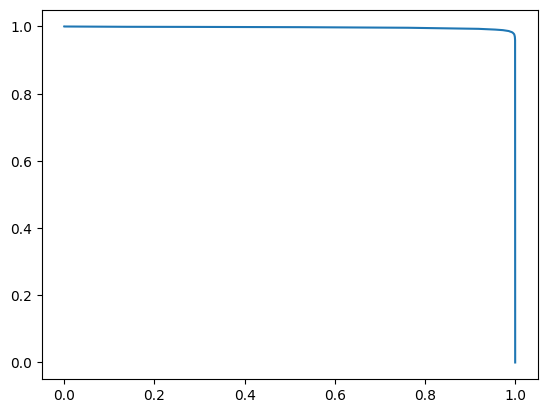

In [57]:
import matplotlib.pyplot as plt
plt.plot(1-np.array(far),1-np.array(frr))

In [58]:
eer_idx = np.argmin(abs(np.array(far)-np.array(frr)))
eer = 1-(far[eer_idx]+frr[eer_idx])/2

In [59]:
eer

0.9860945619241946

In [ ]:
torch.

In [60]:
# 清空显存
torch.cuda.empty_cache()